In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v3_fixed_linspace_logspace_times_200'
path_results = './results/ZTF/LC_MD_FEAT/lc_md_feat_mta_v3_fixed_linspace_logspace_times/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
objects_partitions = pd.read_parquet('./data/partitions/v3/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = [x.encode('utf-8') for x in obj_label['oid'].values]
obj_label

[b'ZTF18adldhip',
 b'ZTF19aasbgeb',
 b'ZTF18aayfbqd',
 b'ZTF19ablyzbl',
 b'ZTF18actabfv',
 b'ZTF18aaztkvq',
 b'ZTF21aaphzsw',
 b'ZTF19aarhrcv',
 b'ZTF17aaajmxw',
 b'ZTF18acrvact',
 b'ZTF22aaahdyl',
 b'ZTF18aacebav',
 b'ZTF19abnqhwd',
 b'ZTF19abjgdow',
 b'ZTF18abklljv',
 b'ZTF18aalaphh',
 b'ZTF23aaaziou',
 b'ZTF17aacihzd',
 b'ZTF22abnmzar',
 b'ZTF17aaaoite',
 b'ZTF18abcurfb',
 b'ZTF18adbbyzu',
 b'ZTF18aaxpqts',
 b'ZTF18aacgwxk',
 b'ZTF18admcecv',
 b'ZTF18abukrnx',
 b'ZTF19aapuibt',
 b'ZTF18aawccep',
 b'ZTF21aahfpup',
 b'ZTF19aaoztzf',
 b'ZTF18aayijfg',
 b'ZTF18abgpcbj',
 b'ZTF18abwbiev',
 b'ZTF18actawil',
 b'ZTF20abyzomt',
 b'ZTF17aabxqbf',
 b'ZTF18abukymf',
 b'ZTF18abvbsoc',
 b'ZTF18actunfi',
 b'ZTF18aazfeau',
 b'ZTF22aaayewi',
 b'ZTF18aaxtcdl',
 b'ZTF18abtoxjw',
 b'ZTF18acdpxfb',
 b'ZTF18aabvmax',
 b'ZTF18abbogne',
 b'ZTF18aapnlus',
 b'ZTF18abmawit',
 b'ZTF19abbxyxi',
 b'ZTF18abscchv',
 b'ZTF18abusyzs',
 b'ZTF18abolzdx',
 b'ZTF19abjbaml',
 b'ZTF18acwuhrk',
 b'ZTF20aasokxu',
 b'ZTF18ac

In [6]:
y_real_test.shape

(8346,)

In [7]:
len(obj_label)

8346

In [8]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [9]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [11]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi', b'ZTF17aaaedvi', b'ZTF17aaafglk', ...,
        b'ZTF23aamxeoe', b'ZTF23aavxvsz', b'ZTF23abcvqkd'], dtype=object),
 'y_test': tensor([10, 11,  5,  ..., 20,  4,  4]),
 'list_y_pred': {'test_16': array([ 2, 11,  5, ...,  4,  4,  9]),
  'test_32': array([10, 11,  5, ...,  4,  4,  9]),
  'test_64': array([10, 11,  5, ..., 20,  4, 20]),
  'test_128': array([10, 11,  5, ..., 20,  4, 20]),
  'test_256': array([10, 11,  5, ..., 20,  4,  9]),
  'test_512': array([10, 11,  5, ..., 20,  4,  9]),
  'test_1024': array([10, 11,  5, ..., 20,  4,  9]),
  'test_2048': array([10, 11,  5, ..., 20,  4,  4])},
 'list_y_pred_prob': {'test_16': array([[6.3325124e-06, 9.0726223e-07, 5.7632983e-01, ..., 1.4453818e-08,
          1.6561431e-06, 3.3142702e-09],
         [3.1193215e-06, 1.7755798e-07, 2.1217830e-04, ..., 7.8063313e-11,
          4.2811411e-07, 3.4232146e-09],
         [1.4973915e-05, 3.6746042e-04, 4.2347096e-02, ..., 2.3503089e-06,
          4.0702231e-05, 2.001440

In [12]:
predictions['list_y_pred_prob']['test_2048'].shape

(41728, 22)

In [13]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob'])

In [14]:
predictions['y_test'].shape

torch.Size([41728])

In [15]:
predictions['SNID'].shape

(41728,)

In [16]:
predictions['labels_final'] = predictions['y_test']
predictions['ids_final'] = np.array(predictions['SNID'])
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41728])


,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing,shorten
b'ZTF17aaaecgi',6.332512e-06,9.072622e-07,5.763298e-01,3.961901e-02,1.726821e-05,0.000650,5.511053e-03,1.577260e-03,3.437789e-06,6.680474e-07,...,1.777109e-03,2.668324e-04,1.270036e-02,1.585977e-06,1.163423e-08,8.606948e-09,1.445382e-08,1.656143e-06,3.314270e-09,16
b'ZTF17aaaedvi',3.119321e-06,1.775580e-07,2.121783e-04,2.911787e-03,1.476184e-05,0.000248,6.323139e-06,4.255838e-04,8.367476e-07,4.539132e-06,...,1.704973e-05,2.332234e-03,3.014523e-04,3.695634e-06,1.226136e-08,1.234036e-08,7.806331e-11,4.281141e-07,3.423215e-09,16
b'ZTF17aaafglk',1.497392e-05,3.674604e-04,4.234710e-02,1.951494e-03,6.229345e-05,0.598996,5.101500e-02,9.670805e-03,8.950667e-04,1.489515e-05,...,4.069524e-02,1.925933e-01,2.871449e-02,1.411509e-05,7.045950e-06,1.647407e-07,2.350309e-06,4.070223e-05,2.001440e-08,16
b'ZTF17aaafiut',1.229505e-05,3.123213e-06,5.678856e-01,2.866346e-02,3.587701e-05,0.003439,3.510207e-02,4.226610e-03,5.001128e-06,3.480327e-06,...,5.405571e-03,1.152561e-03,1.939748e-01,5.214007e-06,1.119401e-07,2.330714e-08,3.027856e-07,2.404524e-05,5.869345e-09,16
b'ZTF17aaafiww',1.084369e-05,6.605939e-06,2.070988e-01,6.294919e-02,2.397431e-05,0.013166,1.000300e-01,1.214969e-02,2.356576e-05,1.115787e-06,...,8.070845e-02,3.256116e-03,1.778096e-01,3.267138e-06,3.363019e-08,5.426908e-09,4.815986e-09,5.333229e-06,3.774081e-09,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'ZTF23aamapva',4.018699e-06,1.017995e-06,2.045664e-04,1.708836e-05,7.292343e-07,0.000251,1.895362e-03,7.510551e-04,1.039156e-06,1.640079e-07,...,7.006554e-05,9.870843e-01,5.176454e-03,2.157898e-07,4.195762e-08,4.439217e-10,3.896924e-09,8.548475e-07,1.504992e-11,2048
b'ZTF23aamsarj',1.539310e-08,1.637243e-08,1.025977e-08,7.206239e-09,1.046564e-01,0.000024,4.211853e-09,3.532748e-08,9.936560e-09,8.017856e-01,...,1.842608e-08,1.048651e-08,1.946865e-08,6.573739e-02,6.540395e-07,4.651113e-11,1.103199e-05,2.778468e-02,1.782764e-09,2048
b'ZTF23aamxeoe',7.587817e-06,5.048245e-06,2.916056e-07,9.487825e-07,3.323230e-02,0.002056,3.150323e-06,8.875516e-06,4.774239e-06,5.953546e-02,...,1.764120e-06,9.380245e-06,2.128700e-06,4.638289e-02,8.979972e-02,1.114656e-05,4.120739e-07,7.689274e-01,5.995637e-08,2048
b'ZTF23aavxvsz',9.697168e-05,2.638418e-06,2.457377e-06,1.669087e-05,9.680361e-01,0.000016,2.610041e-07,1.840442e-05,5.477416e-05,5.546847e-03,...,1.173115e-07,2.139099e-06,1.899842e-07,2.503167e-02,6.210061e-06,9.438123e-07,1.115780e-03,4.386381e-05,4.014570e-07,2048


In [17]:
obj_label

[b'ZTF18adldhip',
 b'ZTF19aasbgeb',
 b'ZTF18aayfbqd',
 b'ZTF19ablyzbl',
 b'ZTF18actabfv',
 b'ZTF18aaztkvq',
 b'ZTF21aaphzsw',
 b'ZTF19aarhrcv',
 b'ZTF17aaajmxw',
 b'ZTF18acrvact',
 b'ZTF22aaahdyl',
 b'ZTF18aacebav',
 b'ZTF19abnqhwd',
 b'ZTF19abjgdow',
 b'ZTF18abklljv',
 b'ZTF18aalaphh',
 b'ZTF23aaaziou',
 b'ZTF17aacihzd',
 b'ZTF22abnmzar',
 b'ZTF17aaaoite',
 b'ZTF18abcurfb',
 b'ZTF18adbbyzu',
 b'ZTF18aaxpqts',
 b'ZTF18aacgwxk',
 b'ZTF18admcecv',
 b'ZTF18abukrnx',
 b'ZTF19aapuibt',
 b'ZTF18aawccep',
 b'ZTF21aahfpup',
 b'ZTF19aaoztzf',
 b'ZTF18aayijfg',
 b'ZTF18abgpcbj',
 b'ZTF18abwbiev',
 b'ZTF18actawil',
 b'ZTF20abyzomt',
 b'ZTF17aabxqbf',
 b'ZTF18abukymf',
 b'ZTF18abvbsoc',
 b'ZTF18actunfi',
 b'ZTF18aazfeau',
 b'ZTF22aaayewi',
 b'ZTF18aaxtcdl',
 b'ZTF18abtoxjw',
 b'ZTF18acdpxfb',
 b'ZTF18aabvmax',
 b'ZTF18abbogne',
 b'ZTF18aapnlus',
 b'ZTF18abmawit',
 b'ZTF19abbxyxi',
 b'ZTF18abscchv',
 b'ZTF18abusyzs',
 b'ZTF18abolzdx',
 b'ZTF19abjbaml',
 b'ZTF18acwuhrk',
 b'ZTF20aasokxu',
 b'ZTF18ac

In [18]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
b'ZTF18adldhip',3.750137e-01,6.096604e-01,0.000002,1.178045e-05,5.768481e-06,0.000051,0.000007,0.000079,1.494726e-02,4.243274e-06,...,0.000003,1.709510e-06,0.000198,0.000007,4.867933e-07,2.544675e-07,2.994202e-09,1.524350e-13,1.444301e-06,6.151985e-12
b'ZTF19aasbgeb',1.042018e-01,8.891425e-01,0.000004,3.939296e-07,1.572039e-05,0.000012,0.000011,0.000025,6.549119e-03,2.861364e-06,...,0.000006,8.206195e-06,0.000013,0.000002,1.267346e-06,3.000558e-06,1.064795e-09,9.293445e-12,8.019298e-07,7.320562e-11
b'ZTF18aayfbqd',1.314427e-05,1.776828e-06,0.199650,7.159489e-02,5.008663e-05,0.000181,0.000351,0.004234,1.225990e-05,2.058112e-06,...,0.184975,1.975744e-04,0.002749,0.001604,2.659109e-06,5.560354e-08,2.667306e-07,9.484811e-10,1.834242e-07,1.418101e-07
b'ZTF19ablyzbl',6.210233e-03,9.907863e-01,0.000040,6.110626e-07,3.373273e-05,0.000041,0.000051,0.000041,2.684850e-03,8.203110e-07,...,0.000019,3.999909e-05,0.000020,0.000004,6.010974e-07,3.078866e-07,7.474221e-10,2.075623e-10,1.165575e-06,1.233216e-10
b'ZTF18actabfv',2.321237e-05,1.339521e-06,0.000162,9.830343e-01,1.408326e-06,0.000236,0.000002,0.001585,1.564755e-05,9.030266e-08,...,0.000664,9.547176e-07,0.012090,0.000423,1.631424e-08,1.467685e-10,1.539302e-12,1.664775e-13,4.838144e-09,2.493175e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'ZTF18abdlmwe',1.247664e-07,3.738070e-09,0.000313,1.518787e-03,1.233274e-07,0.000007,0.000060,0.000784,6.164999e-07,5.585538e-09,...,0.996338,4.345673e-05,0.000087,0.000019,4.117096e-09,4.687225e-12,7.073148e-11,7.180952e-13,1.363521e-09,1.760334e-11
b'ZTF18abnueof',3.877517e-06,2.399825e-06,0.000008,6.180270e-07,4.902882e-07,0.000107,0.977394,0.008791,3.251965e-06,1.681914e-07,...,0.003903,2.730255e-03,0.006149,0.000422,3.346869e-07,4.326875e-08,9.488305e-10,2.497375e-10,6.788864e-07,3.689161e-11
b'ZTF17aaagvih',1.138291e-04,1.611492e-05,0.000105,9.147555e-01,1.803722e-05,0.063972,0.000024,0.000325,1.395091e-03,1.289512e-05,...,0.001590,4.071089e-05,0.010562,0.000239,9.419288e-07,1.641253e-08,2.280233e-11,2.763310e-12,3.242129e-07,5.151695e-11
b'ZTF17aabpjme',6.249141e-08,1.066074e-06,0.000010,3.003342e-06,1.302450e-07,0.000091,0.001228,0.000103,2.044461e-05,2.361564e-08,...,0.003488,9.949421e-01,0.000004,0.000067,6.141376e-08,4.456460e-12,4.206756e-12,1.519307e-14,5.441090e-09,2.111013e-09


In [19]:
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
b'ZTF18adldhip',3.750137e-01,6.096604e-01,0.000002,1.178045e-05,5.768481e-06,0.000051,0.000007,0.000079,1.494726e-02,4.243274e-06,...,0.000003,1.709510e-06,0.000198,0.000007,4.867933e-07,2.544675e-07,2.994202e-09,1.524350e-13,1.444301e-06,6.151985e-12
b'ZTF19aasbgeb',1.042018e-01,8.891425e-01,0.000004,3.939296e-07,1.572039e-05,0.000012,0.000011,0.000025,6.549119e-03,2.861364e-06,...,0.000006,8.206195e-06,0.000013,0.000002,1.267346e-06,3.000558e-06,1.064795e-09,9.293445e-12,8.019298e-07,7.320562e-11
b'ZTF18aayfbqd',1.314427e-05,1.776828e-06,0.199650,7.159489e-02,5.008663e-05,0.000181,0.000351,0.004234,1.225990e-05,2.058112e-06,...,0.184975,1.975744e-04,0.002749,0.001604,2.659109e-06,5.560354e-08,2.667306e-07,9.484811e-10,1.834242e-07,1.418101e-07
b'ZTF19ablyzbl',6.210233e-03,9.907863e-01,0.000040,6.110626e-07,3.373273e-05,0.000041,0.000051,0.000041,2.684850e-03,8.203110e-07,...,0.000019,3.999909e-05,0.000020,0.000004,6.010974e-07,3.078866e-07,7.474221e-10,2.075623e-10,1.165575e-06,1.233216e-10
b'ZTF18actabfv',2.321237e-05,1.339521e-06,0.000162,9.830343e-01,1.408326e-06,0.000236,0.000002,0.001585,1.564755e-05,9.030266e-08,...,0.000664,9.547176e-07,0.012090,0.000423,1.631424e-08,1.467685e-10,1.539302e-12,1.664775e-13,4.838144e-09,2.493175e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'ZTF18abdlmwe',1.247664e-07,3.738070e-09,0.000313,1.518787e-03,1.233274e-07,0.000007,0.000060,0.000784,6.164999e-07,5.585538e-09,...,0.996338,4.345673e-05,0.000087,0.000019,4.117096e-09,4.687225e-12,7.073148e-11,7.180952e-13,1.363521e-09,1.760334e-11
b'ZTF18abnueof',3.877517e-06,2.399825e-06,0.000008,6.180270e-07,4.902882e-07,0.000107,0.977394,0.008791,3.251965e-06,1.681914e-07,...,0.003903,2.730255e-03,0.006149,0.000422,3.346869e-07,4.326875e-08,9.488305e-10,2.497375e-10,6.788864e-07,3.689161e-11
b'ZTF17aaagvih',1.138291e-04,1.611492e-05,0.000105,9.147555e-01,1.803722e-05,0.063972,0.000024,0.000325,1.395091e-03,1.289512e-05,...,0.001590,4.071089e-05,0.010562,0.000239,9.419288e-07,1.641253e-08,2.280233e-11,2.763310e-12,3.242129e-07,5.151695e-11
b'ZTF17aabpjme',6.249141e-08,1.066074e-06,0.000010,3.003342e-06,1.302450e-07,0.000091,0.001228,0.000103,2.044461e-05,2.361564e-08,...,0.003488,9.949421e-01,0.000004,0.000067,6.141376e-08,4.456460e-12,4.206756e-12,1.519307e-14,5.441090e-09,2.111013e-09


In [20]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['QSO', 'QSO', 'LPV', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

In [21]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

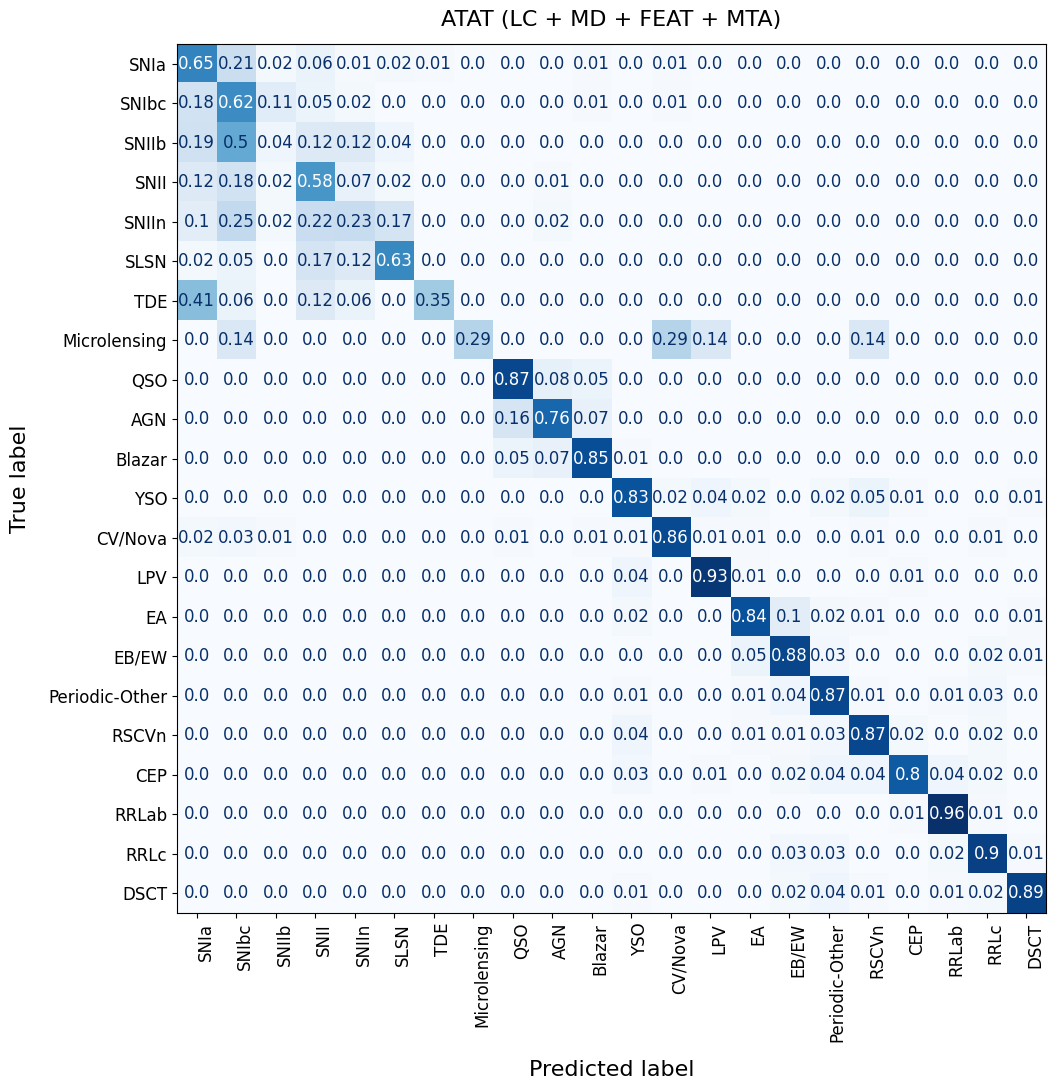

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MD + FEAT + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.6971510495960342